In [1]:
from typing import List, Union

from numpy import sqrt, isinf
import pandas as pd
import xarray as xr
xr.set_options(keep_attrs=True,
               display_expand_data=False)

import plotly.express as px
import plotly.io as pio
# pio.renderers.default='png'

import yfinance as yf


In [2]:
def xr_pct_change(da: xr.DataArray, dim: str, periods: int = 1) -> xr.DataArray:
    """
    Calculate the percent change between values of an xarray DataArray along a specified dimension,
    similar to the pandas pct_change function.

    Parameters
    ----------
    da : xr.DataArray
        The input xarray DataArray.
    dim : str
        The dimension along which to calculate the percent change.
    periods : int, optional
        The number of periods to shift for calculating percent change, by default 1.

    Returns
    -------
    xr.DataArray
        DataArray of the same shape with percent changes computed along the specified dimension.

    Examples
    --------
    >>> da = xr.DataArray([1, 2, 4, 8], dims='time')
    >>> xr_pct_change(da, dim='time')
    <xarray.DataArray (time: 4)>
    array([nan, 1. , 1. , 1. ])
    Dimensions without coordinates: time

    Notes
    -----
    - Generated by ChatGPT (v2.0) on 2024-10-22.
    - Prompt: "Please write a pct_change function for an xarray DataArray in the style of pandas pct_change function.
      Please be careful to note that the diff function in xarray uses the numpy convention, not the pandas convention."
    """
    shifted = da.shift({dim: periods})
    pct_change = (da - shifted) / shifted
    # pct_change = pct_change.where(~isinf(pct_change))  # Handle division by zero cases
    return pct_change

In [3]:
def get_yf_data(asset_list: List[str]) -> xr.DataArray:
    return (yf.download(asset_list)
            .rename_axis(index='date', columns=['ohlcv_type', 'asset'])
            .rename(index={'Ticker': 'asset'})
            .rename(columns=lambda col: col.lower(), level='ohlcv_type')
            .stack(['asset', 'ohlcv_type'], future_stack=True)
            .to_xarray())


def get_ewm_corr(ret: xr.DataArray, halflife: int) -> xr.DataArray:
    return (ret.to_pandas()
            .ewm(halflife=halflife)
            .corr()
            .rename_axis(columns=lambda name: f"{name}_1")
            .stack()
            .rename('corr')
            .to_xarray())


def get_volatility_set(ret: xr.DataArray, halflifes: List[int], dim: str='date') -> xr.DataArray:
    return xr.concat([ret.rolling_exp({dim: h}, window_type='halflife').std() * sqrt(252)
                      for h in halflifes],
                     dim=pd.Index(halflifes, name='vol_type'))


def get_correlation_set(ret: xr.DataArray, halflifes: List[int]) -> xr.DataArray:
    return xr.concat([get_ewm_corr(ret, h) for h in halflifes],
                     dim=pd.Index(halflifes, name='corr_type'))


def get_factor_data(asset_list: List[str], halflifes: List[int]) -> xr.Dataset:
    ds = xr.Dataset()
    ds['ohlcv'] = get_yf_data(asset_list) #.to_dataset(name='ohlcv')
    ds['cret']  = ds['ohlcv'].sel(ohlcv_type='adj close')
    ds['ret']   = xr_pct_change(ds['cret'], 'date')
    ds['vol']   = get_volatility_set(ds['ret'], halflifes)
    ds['corr']  = get_correlation_set(ds['ret'], halflifes)
    return ds

In [4]:
factor_master = pd.read_excel('factor_master.xlsx', sheet_name='read', index_col='factor_name')
factor_list = factor_master.query('active == 1')['etf'].to_list()
halflifes = [21, 63, 126, 252, 512]
ds = get_factor_data(factor_list, halflifes)

[*********************100%%**********************]  6 of 6 completed


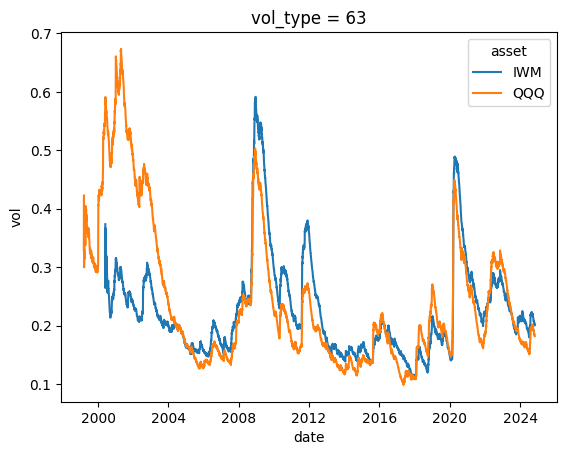

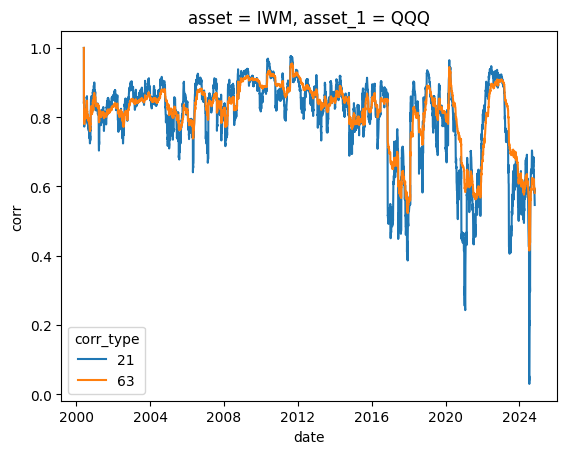

In [5]:
import matplotlib.pyplot as plt

ds.vol.sel(asset=['IWM', 'QQQ'], vol_type=[63]).plot(hue='asset')
plt.show()

ds.corr.sel(asset='IWM', asset_1='QQQ', corr_type=[21, 63]).plot(hue='corr_type')
plt.show()

In [6]:
ds

<xarray.Dataset> Size: 17MB
Dimensions:     (date: 7997, asset: 6, ohlcv_type: 6, vol_type: 5, asset_1: 6,
                 corr_type: 5)
Coordinates:
  * date        (date) datetime64[ns] 64kB 1993-01-29 1993-02-01 ... 2024-10-31
  * asset       (asset) object 48B 'FEZ' 'HYG' 'IWM' 'LQD' 'QQQ' 'SPY'
  * ohlcv_type  (ohlcv_type) object 48B 'adj close' 'close' ... 'open' 'volume'
  * vol_type    (vol_type) int64 40B 21 63 126 252 512
  * asset_1     (asset_1) object 48B 'FEZ' 'HYG' 'IWM' 'LQD' 'QQQ' 'SPY'
  * corr_type   (corr_type) int64 40B 21 63 126 252 512
Data variables:
    ohlcv       (date, asset, ohlcv_type) float64 2MB nan nan ... 575.6 1.87e+07
    cret        (date, asset) float64 384kB nan nan nan nan ... 108.9 nan 570.7
    ret         (date, asset) float64 384kB nan nan nan ... -0.002872 nan -0.016
    vol         (vol_type, date, asset) float64 2MB nan nan nan ... 0.223 0.1742
    corr        (corr_type, date, asset, asset_1) float64 12MB nan nan ... 1.0

In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Charting scratch

In [ ]:
def format_plotly_title(title: str, subtitles: List[str]) -> dict:
    """
    Format a title and a list of subtitles for a Plotly chart.

    Parameters
    ----------
    title : str
        The main title of the chart.
    subtitles : List[str]
        A list of subtitles for the chart.

    Returns
    -------
    dict
        A dictionary containing the formatted title and subtitles for Plotly.
    """
    # subtitle_text = "<br>".join([f"<sup>{subtitle}</sup>" for subtitle in subtitles])
    subtitle_text = f'<span style="font size: 12px;">{"<br>".join(subtitles)}</span>'
    return {
        'text': f'{title}<br><span style="font size: 12px;">{"<br>".join(subtitles)}</span>',
        # 'x': 0.5,
        # 'xanchor': 'center',
        # 'yanchor': 'top'
    }

# Example usage:
formatted_title = format_plotly_title("Main Title", ["Subtitle 1", "Subtitle 2"])
fig.update_layout(title=formatted_title)
fig.show()
formatted_title

In [ ]:
from typing import Union

def format_plotly_title(title: str, subtitles: Union[str, List[str]]) -> dict:
    """
    Format a title and a list of subtitles for a Plotly chart.

    Parameters
    ----------
    title : str
        The main title of the chart.
    subtitles : Union[str, List[str]]
        A single subtitle or a list of subtitles for the chart.

    Returns
    -------
    dict
        A dictionary containing the formatted title and subtitles for Plotly.
    """
    if isinstance(subtitles, str):
        subtitles = [subtitles]
    subtitle_text = f'<span style="font size: 12px;">{"<br>".join(subtitles)}</span>'
    return {
        'text': f'{title}<br><span style="font size: 12px;">{"<br>".join(subtitles)}</span>',
    }

# Example usage:
formatted_title = format_plotly_title("Main Title", "Single Subtitle")
fig.update_layout(title=formatted_title)
fig.show()
formatted_title


In [ ]:
def plotly_line_chart(da: xr.DataArray, x: str, y: str, color: str = None, title: str = "Line Chart") -> None:
    """
    Produce a Plotly Express line chart given an xarray DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The input xarray DataArray.
    x : str
        The name of the dimension to use for the x-axis.
    y : str
        The name of the dimension to use for the y-axis.
    color : str, optional
        The name of the dimension to use for color grouping, by default None.
    title : str, optional
        The title of the chart, by default "Line Chart".

    Returns
    -------
    None
    """
    df = da.to_series().reset_index()
    fig = px.line(df, x=x, y=y, color=color, title=title, template='plotly_white')
    fig.show()

# Example usage:
# plotly_line_chart(ds.vol, x='date', y='vol', color='vol_type', title='Volatility Over Time')

In [ ]:
vol_type_list_fig = [21, 63]


fig_sel = {'vol_type': [21, 63],
           'asset': 'QQQ'}

def px_line(da, x, y, color=None):
    fig_format = {'template': 'plotly_white', 'height': 500, 'width': 1000}
    df = da.sel(**fig_sel).to_series().reset_index()
    title = 'Volatility'
    fig = px.line(df, x=x, y=y, color='vol_type', title=title, **fig_format)
    fig.show()
    
px_line(data.vol, x='date', y='vol')

# MDS scratch

In [ ]:
from sklearn.manifold import MDS
from numpy import sqrt

def multi
correlation_matrix = ds.corr.sel(date='2024-10-25', corr_type=63).to_pandas()
dissimilarity_matrix = sqrt(1 - correlation_matrix**2)


mds = MDS(dissimilarity='precomputed', random_state=42)
mds_results = mds.fit_transform(dissimilarity_matrix)
mds_df = pd.DataFrame(mds_results, index=dissimilarity_matrix.index, columns=['dim1', 'dim2'])


print(mds_df)
mds_df.plot.scatter(x='dim1', y='dim2')

px.scatter(mds_df.reset_index(), x='dim1', y='dim2', hover_name='asset')

In [ ]:
from sklearn.manifold import MDS

corr_df = ds.corr.sel(date='2024-10-25', corr_type=63).to_pandas()
mds = MDS(dissimilarity='precomputed', random_state=42)
mds_results = mds.fit_transform(1 - corr_df)
mds_df = pd.DataFrame(mds_results, index=corr_df.index, columns=['MDS1', 'MDS2'])
print(mds_df)
mds_df.plot.scatter(x='MDS1', y='MDS2')

px.scatter(mds_df.reset_index(), x='MDS1', y='MDS2', hover_name='asset')

In [ ]:
mds_results_list = []

for date in ds.date.values:
    corr_df = ds.corr.sel(date=date, corr_type=63).to_pandas()
    imputer = SimpleImputer(strategy='mean')
    corr_df_imputed = imputer.fit_transform(1 - corr_df)
    mds = MDS(dissimilarity='precomputed', random_state=42)
    mds_results = mds.fit_transform(corr_df_imputed)
    mds_results = mds.fit_transform(1 - corr_df)
    mds_results_list.append(mds_results)

mds_results_array = np.stack(mds_results_list)
mds_da = xr.DataArray(mds_results_array, coords=[ds.date, corr_df.index, ['MDS1', 'MDS2']], dims=['date', 'asset', 'mds_dim'])
print(mds_da)
